<a href="https://colab.research.google.com/github/kmuhan/kmuhandeeplearning/blob/main/face_mask_detection_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask detector model by using VGGNET-16 simulated with keras

***Data Reference:*** [Kaggle Face Mask Detection](https://www.kaggle.com/andrewmvd/face-mask-detection)



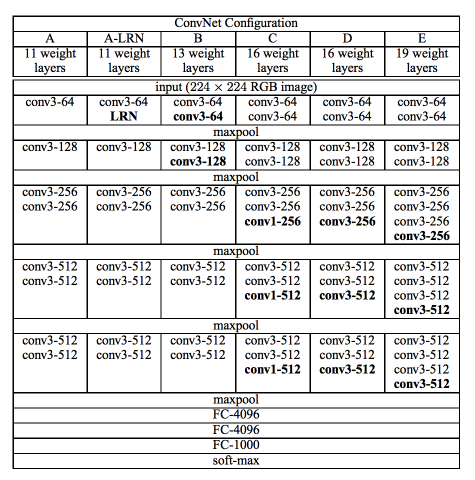

In [1]:
import os
from PIL import Image
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# **Set model layers and model with VGG-16**

In [2]:
image_input = keras.Input(shape=(224, 224, 3), name="img")
x = layers.Conv2D(64, 3, activation='relu', padding='same', name='conv3-64-1')(image_input)
x = layers.Conv2D(64, 3, activation='relu', padding='same', name='conv3-64-2')(x)
x = layers.MaxPool2D(2, name='maxpool2-1')(x)

x = layers.Conv2D(128, 3, activation='relu', padding='same', name='conv3-128-1')(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same', name='conv3-128-2')(x)
x = layers.MaxPool2D(2, name='maxpool2-2')(x)

x = layers.Conv2D(256, 3, activation='relu', padding='same', name='conv3-256-1')(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same', name='conv3-256-2')(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same', name='conv3-256-3')(x)
x = layers.MaxPool2D(2, name='maxpool2-3')(x)

x = layers.Conv2D(512, 3, activation='relu', padding='same', name='conv3-512-1')(x)
x = layers.Conv2D(512, 3, activation='relu', padding='same', name='conv3-512-2')(x)
x = layers.Conv2D(512, 3, activation='relu', padding='same', name='conv3-512-3')(x)
x = layers.MaxPool2D(2, name='maxpool2-4')(x)

x = layers.Conv2D(512, 3, activation='relu', padding='same', name='conv3-512-4')(x)
x = layers.Conv2D(512, 3, activation='relu', padding='same', name='conv3-512-5')(x)
x = layers.Conv2D(512, 3, activation='relu', padding='same', name='conv3-512-6')(x)
x = layers.MaxPool2D(2, name='maxpool2-5')(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu', name='FCL-4096-1')(x)
x = layers.Dropout(0.5, name='dropout-1')(x)
x = layers.Dense(4096, activation='relu', name='FCL-4096-2')(x)
x = layers.Dropout(0.5, name='dropout-2')(x)
x = layers.Dense(1000, activation='relu', name='FCL-1000')(x)
output = layers.Dense(2, activation='softmax', name='softmax')(x)

detector = keras.Model(image_input, output, name="mask_detection_vgg19")

# **Get summary of model**

In [3]:
detector.summary()

Model: "mask_detection_vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 224, 224, 3)]     0         
                                                                 
 conv3-64-1 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 conv3-64-2 (Conv2D)         (None, 224, 224, 64)      36928     
                                                                 
 maxpool2-1 (MaxPooling2D)   (None, 112, 112, 64)      0         
                                                                 
 conv3-128-1 (Conv2D)        (None, 112, 112, 128)     73856     
                                                                 
 conv3-128-2 (Conv2D)        (None, 112, 112, 128)     147584    
                                                                 
 maxpool2-2 (MaxPooling2D)   (None, 56, 56, 12

# **Get model plot**

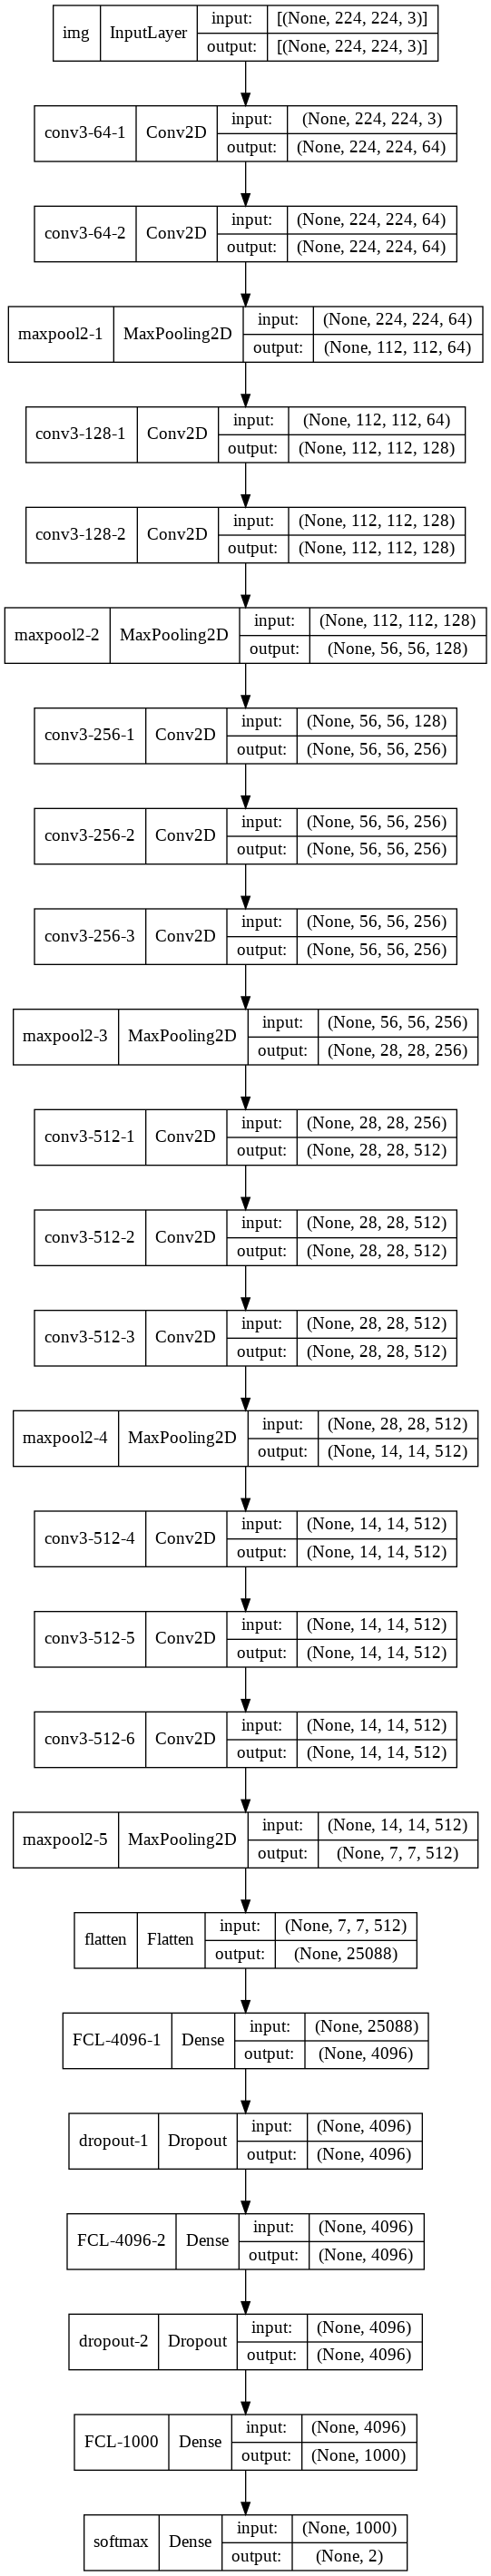

In [4]:
keras.utils.plot_model(detector, "mask_detector_vgg19.png", show_shapes=True)

# **Extract 224x224 size image from image files and xml annotations**

In [5]:
def extract_224(image, xml):
  annotation = ET.parse(xml)
  root = annotation.getroot()

  images = []
  corrects = []

  for obj in root.findall('object'):
    # with_mask 인지 without_mask 인지 extract
    is_masked = True if (obj.find('name').text == 'with_mask') else False
    correct = [1, 0] if is_masked == True else [0, 1]

    bndbox = obj.find('bndbox')
    width = int(bndbox.find('xmax').text) - int(bndbox.find('xmin').text)
    height = int(bndbox.find('ymax').text) - int(bndbox.find('ymin').text)
    square_w = width if (width <= height) else height
    
    area = (int(bndbox.find('xmin').text), int(bndbox.find('ymin').text), int(bndbox.find('xmin').text) + square_w, int(bndbox.find('ymin').text) + square_w)
    image_cropped = image.crop(area)
    image_224 = image_cropped.resize((224, 224))

    images.append(image_224)
    corrects.append(correct)

  return images, corrects

image_array = []
correct_array = []

# 마운트 된 구글 드라이브에서 이미지와 xml 파일 read 할 path
image_path = "/content/drive/MyDrive/archive/images_jpg"
xml_path = "/content/drive/MyDrive/archive/annotations"

for img in os.listdir(image_path):
  xml = (xml_path + "/" + img[:-4] + ".xml")
  image = Image.open(image_path + "/" +img)

  image_224, correct = extract_224(image, xml)

  for im in image_224:
    image_array.append(np.array(im)/255)
  for cor in correct:
    correct_array.append(cor)

# **Change array as np.array and split data to train, test index**

In [6]:
image_array = np.array(image_array)
correct_array = np.array(correct_array)
print(len(image_array))
print(len(correct_array))

index = np.arange(len(image_array))
index_train = index[index%4 != 0]
index_test = index[index%4 == 0]

4072
4072


# **Indexing datasets and fit model**

In [7]:
x_train = image_array[index_train, :]
y_train = correct_array[index_train, :]
x_test = image_array[index_test, :]
y_test = correct_array[index_test, :]

del image_array, correct_array

opt = keras.optimizers.Adagrad(learning_rate=0.01)
detector.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=opt,
    metrics=["accuracy"],
)

history = detector.fit(x_train, y_train, batch_size=8, epochs=20)

Epoch 1/20
382/382 [==============================] - 177s 370ms/step - loss: 0.5099 - accuracy: 0.7967
Epoch 2/20
382/382 [==============================] - 137s 358ms/step - loss: 0.4106 - accuracy: 0.8084
Epoch 3/20
382/382 [==============================] - 137s 358ms/step - loss: 0.2909 - accuracy: 0.8867
Epoch 4/20
382/382 [==============================] - 137s 358ms/step - loss: 0.2031 - accuracy: 0.9250
Epoch 5/20
382/382 [==============================] - 137s 358ms/step - loss: 0.1906 - accuracy: 0.9293
Epoch 6/20
382/382 [==============================] - 137s 358ms/step - loss: 0.1832 - accuracy: 0.9312
Epoch 7/20
382/382 [==============================] - 137s 358ms/step - loss: 0.1742 - accuracy: 0.9375
Epoch 8/20
382/382 [==============================] - 137s 357ms/step - loss: 0.1728 - accuracy: 0.9375
Epoch 9/20
382/382 [==============================] - 137s 358ms/step - loss: 0.1682 - accuracy: 0.9365
Epoch 10/20
382/382 [==============================] - 137s 358m

# **Evaluate model as test**

In [8]:
test_scores = detector.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

32/32 - 27s - loss: 0.2275 - accuracy: 0.9145 - 27s/epoch - 845ms/step
Test loss: 0.22754426300525665
Test accuracy: 0.9145383238792419


# **Plotting model**

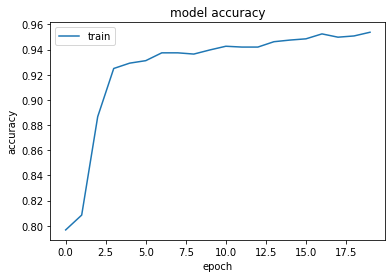

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Save model as keras model object**

In [10]:
detector.save("/content/drive/MyDrive/face_mask_detector")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/face_mask_detector/assets


# **Use model by prediction**

Mask


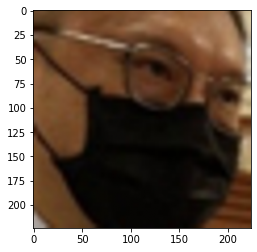

In [31]:
img = x_test[0:1]
prediction = detector.predict(img)
ans = np.argmax(prediction[0])

if ans == 0:
  print("Mask")
else:
  print("No Mask")

plt.imshow(img[0])

# **Add Capturable feature and predict realtime captured image**

In [81]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

def face_detection(img, ans):
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.01, 2, 0, minSize=(30, 30))

  if(ans == 0):
    c = (0, 255, 0)
    text = "MASK"
  else:
    c = (255, 0, 0)
    text = "NO MASK"

  for (x,y,w,h) in faces:
    cv2.rectangle(img, (x,y), (x+w,y+h), thickness=2, color=c)
    cv2.putText(img, text, (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

  plt.imshow(img)

<IPython.core.display.Javascript object>

MASK


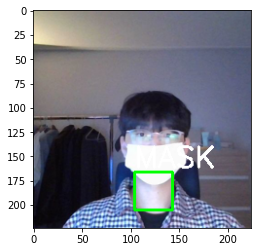

In [138]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
try:
  filename = take_photo()
  # Show the image which was just taken.
  img = Image.open(filename, "r")
  img_cropped = img.crop((80, 0, 560, 480))
  img_224 = np.array(img_cropped.resize((224, 224)))
  img_arr = []
  img_arr.append(img_224)
  img_arr.append(img_224)
  img_arr = np.array(img_arr)
  pred = detector.predict(img_arr[0:1])
  ans = np.argmax(pred[0])
  if(ans == 0):
    print("MASK")
  else:
    print("NO MASK")
  face_detection(img_224, ans)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))